In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import re

sns.set()


def gethighest(vals, prefix="logall_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

        
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

In [2]:
params = []
prefix = '/home/pecoffet/remoterobo'

paths = sorted([]
                  + glob.glob(f"{prefix}/logs/lionscross2/*/*/*/*/*/rep00/", recursive=True)
                  )
#paths = sorted(glob.glob(f"{prefix}/logs/lions-nvar-*-2019-06-*/**/rep00/", recursive=True))
for path in paths:
    print(path)
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*')), delimiter="\t")
    except Exception as e:
        print(e)
        continue
    curparam = readparams(glob.glob(path + 'properties*')[0])
    logall.query(f'nbOnOpp == {curparam["nOpti"]}')["curCoopNoCoef"].mean()
    nmod = logall['nbOnOpp'].mode()[0]
    coopopti = np.nanmean(logall.query(f"nbOnOpp == {curparam['nOpti']}")["curCoopNoCoef"])
    if np.isnan(coopopti):  # WARNING, bold choice !
        coopopti = 0
    coopmod =  np.nanmean(logall.query(f'nbOnOpp == {nmod}')["curCoopNoCoef"].mean())
    params.append({'path':path, 'params':curparam, 'coopopti': coopopti, 'coopmod': coopmod})



/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_01/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_02/rep00/


/home/pecoffet/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_03/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_04/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_05/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_06/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_07/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_08/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o10/i1000/run_09/rep00/
/home/pecoffet/remot

/home/pecoffet/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pecoffet/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o20/i5000/run_10/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o20/i5000/run_11/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o20/i5000/run_12/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o30/i1000/run_01/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o30/i1000/run_02/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o30/i1000/run_03/rep00/
/home/pecoffet/remoterobo/logs/lionscross2/lions-work-tol0.2-pop100-fake_1-b10-nopti-2-2019-08-08-1740/lion_megabig/o30/i1000/run_04/rep00/
/home/pecoffet/remot

In [11]:
diffkeys = set()
missingkeys = set()
for i in range(len(params)):
    for key in params[i]['params'].keys():
        try:
            if any(params[j]['params'][key] != params[i]['params'][key] for j in range(0, len(params) - 1)):
                diffkeys.add(key)
        except KeyError:
            missingkeys.add(key)

In [12]:
excluded = ['gSeed', 'gLogFilename', 'path']
processed = []
for elem in params:
    param = elem['params']
    ess = param['meanA'] / param['nOpti']
    so = param['meanA'] + param['b'] / float(param['nOpti'])
    outdict = {'coopopti': (elem['coopopti'] - ess) / (so - ess) , 'truecoopopti': elem['coopopti'],
               'coopmod': (elem['coopmod'] - ess) / (so - ess) , 'truecoopmod': elem['coopmod']}
    for key in diffkeys:
        if key in excluded: continue
        outdict[key] = elem['params'][key]
    processed.append(outdict)
    for key in missingkeys:
        if key in excluded: continue
        outdict[key] = elem['params'].get(key, False)
df = pd.DataFrame(processed)
normalized_df=(df-df.mean())/df.std()

In [13]:
df

,coopmod,coopopti,evaluationTime,gNbOfPhysicalObjects,gRandomSeed,nOpti,nTolerance,takeVideo,truecoopmod,truecoopopti
0,1.666663,-0.333333,1000.0,10.0,-5.246967e+08,2.0,0.2,True,1.499997e+01,0.000000e+00
1,-0.241430,-0.333333,1000.0,10.0,-5.246982e+08,2.0,0.2,True,6.892771e-01,0.000000e+00
2,-0.332167,-0.333333,1000.0,10.0,-5.246965e+08,2.0,0.2,True,8.748856e-03,0.000000e+00
3,0.838717,-0.333333,1000.0,10.0,-5.246988e+08,2.0,0.2,True,8.790379e+00,0.000000e+00
4,-0.297627,-0.333333,1000.0,10.0,-5.246967e+08,2.0,0.2,True,2.677980e-01,0.000000e+00
5,1.656521,-0.333333,1000.0,10.0,-5.246967e+08,2.0,0.2,True,1.492391e+01,0.000000e+00
6,1.530862,-0.333333,1000.0,10.0,-5.246985e+08,2.0,0.2,True,1.398147e+01,0.000000e+00
7,1.661720,-0.333333,1000.0,10.0,-5.246987e+08,2.0,0.2,True,1.496290e+01,0.000000e+00
8,-0.301199,-0.333333,1000.0,10.0,-5.246984e+08,2.0,0.2,True,2.410090e-01,0.000000e+00
9,1.507823,-0.333333,1000.0,10.0,-5.246988e+08,2.0,0.2,True,1.380867e+01,0.000000e+00


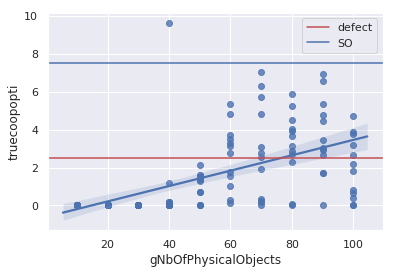

In [72]:
nopti = 2
sns.regplot(x='gNbOfPhysicalObjects', y='truecoopopti', data=df.query(f'nOpti == {nopti} and nTolerance == 0.2 and evaluationTime == 50000'))
plt.plot()
plt.axhline(5/nopti, label='defect', c='r')
plt.axhline(5+5*(nopti-1)/nopti, label='SO', c='b')
plt.legend()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           truecoopopti   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03870
Date:                Mon, 19 Aug 2019   Prob (F-statistic):              0.844
Time:                        14:16:41   Log-Likelihood:                -4015.3
No. Observations:                2112   AIC:                             8035.
Df Residuals:                    2110   BIC:                             8046.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9168      0.043     21.473      0.000       0.833       1.001
evaluationTime -4.087e-07   2.08e-06     -0.197      0.844   -4.48e-06    3.67e-06
==============================================================================
Omnibus:                     1134.200   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7749.249
Skew:                           2.505   Prob(JB):                         0.00
Kurtosis:                      10.935   Cond. No.                     2.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

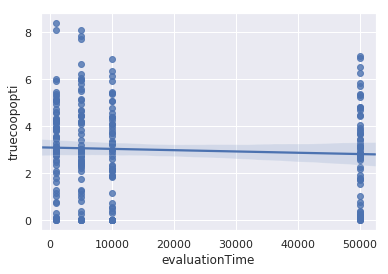

In [76]:
sns.regplot(x='evaluationTime', y='truecoopopti', data=df.query(f'nOpti == {nopti} and nTolerance == 0.2 and gNbOfPhysicalObjects > 50'))
sm.ols(formula='truecoopopti ~ evaluationTime', data=df).fit().summary()

In [15]:
import statsmodels.formula.api as sm

In [16]:
#normalized_df['nbRobots'] = normalized_df['gInitialNumberOfRobots']
normalized_df['nbObj'] = normalized_df['gNbOfPhysicalObjects']

normalized_df

,coopmod,coopopti,evaluationTime,gNbOfPhysicalObjects,gRandomSeed,nOpti,nTolerance,takeVideo,truecoopmod,truecoopopti,nbObj
0,3.277269,-1.051755,-0.623764,-1.552676,-0.358261,-0.804867,-0.719025,1.843472,4.832960,-0.562980,-1.552676
1,-0.677235,-1.051755,-0.623764,-1.552676,-0.358262,-0.804867,-0.719025,1.843472,-0.386042,-0.562980,-1.552676
2,-0.865287,-1.051755,-0.623764,-1.552676,-0.358261,-0.804867,-0.719025,1.843472,-0.634225,-0.562980,-1.552676
3,1.561359,-1.051755,-0.623764,-1.552676,-0.358263,-0.804867,-0.719025,1.843472,2.568368,-0.562980,-1.552676
4,-0.793703,-1.051755,-0.623764,-1.552676,-0.358261,-0.804867,-0.719025,1.843472,-0.539752,-0.562980,-1.552676
5,3.256250,-1.051755,-0.623764,-1.552676,-0.358261,-0.804867,-0.719025,1.843472,4.805219,-0.562980,-1.552676
6,2.995824,-1.051755,-0.623764,-1.552676,-0.358263,-0.804867,-0.719025,1.843472,4.461519,-0.562980,-1.552676
7,3.267024,-1.051755,-0.623764,-1.552676,-0.358263,-0.804867,-0.719025,1.843472,4.819439,-0.562980,-1.552676
8,-0.801106,-1.051755,-0.623764,-1.552676,-0.358263,-0.804867,-0.719025,1.843472,-0.549522,-0.562980,-1.552676
9,2.948075,-1.051755,-0.623764,-1.552676,-0.358263,-0.804867,-0.719025,1.843472,4.398502,-0.562980,-1.552676


In [52]:
result = sm.ols(formula="truecoopopti ~ gNbOfPhysicalObjects + nTolerance + nOpti + evaluationTime", data=df).fit()

In [53]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           truecoopopti   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     56.09
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           5.15e-45
Time:                        13:57:59   Log-Likelihood:                -3908.5
No. Observations:                2112   AIC:                             7827.
Df Residuals:                    2107   BIC:                             7855.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3534      0.101      3.504      0.000       0.156       0.551
gNbOfPhysicalObjects     0.0162      0.001     13.666      0.000       0.014       0.018
nTolerance              -0.2557      0.095     -2.692      0.007      -0.442      -0.069
nOpti                   -0.0206      0.004     -4.889      0.000      -0.029      -0.012
evaluationTime       -1.888e-06   2.12e-06     -0.889      0.374   -6.05e-06    2.28e-06
==============================================================================
Omnibus:                     1104.736   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8594.818
Skew:                           2.361   Prob(JB):                         0.00
Kurtosis:                      11.681   Cond. No.                     7.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
df

,coopmod,coopopti,gNbOfPhysicalObjects,gRandomSeed,nOpti,takeVideo,truecoopmod,truecoopopti
0,0.829634,0.829634,60.0,-1.529695e+09,2.0,True,8.722252e+00,8.722252
1,-0.168664,-0.168664,60.0,-1.529709e+09,2.0,True,1.235019e+00,1.235019
2,-0.089245,-0.089245,60.0,-1.529722e+09,2.0,True,1.830663e+00,1.830663
3,-0.025027,-0.025027,60.0,-1.529728e+09,2.0,True,2.312297e+00,2.312297
4,0.380983,0.380983,60.0,-1.529729e+09,2.0,True,5.357375e+00,5.357375
5,-0.133827,-0.133827,60.0,-1.529728e+09,2.0,True,1.496298e+00,1.496298
6,0.319770,0.319770,60.0,-3.607232e+08,2.0,True,4.898275e+00,4.898275
7,0.656965,0.656965,60.0,-3.607232e+08,2.0,True,7.427235e+00,7.427235
8,0.997578,NaN,10.0,1.395472e+09,2.0,True,9.981835e+00,NaN
9,-0.280251,NaN,10.0,1.395482e+09,2.0,True,3.981161e-01,NaN
